Начнем с импорта нужных нам библиотек.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sc
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder


## Данные

In [2]:
data_xlsx = pd.read_excel('first_practice_dataframe.xlsx')
# 8 вариант
data = data_xlsx[['cat11_nationality', 'cat14_temprature', 'num1_8', 'num2_8', 'num3_8']]
data

,cat11_nationality,cat14_temprature,num1_8,num2_8,num3_8
0,german,Very Hot,247.159357,233.346229,731.516449
1,German,cold,668.812973,96.173995,726.139127
2,german,Very Hot,236.218871,1.799639,742.322785
3,German,Very Hot,989.929212,526.862875,767.297661
4,german,cold,88.636793,64.834346,767.944298
...,...,...,...,...,...
995,French,Very Hot,693.456750,62.973627,756.731417
996,German,cold,172.961735,64.458428,713.537068
997,German,Very Hot,196.283378,33.545698,750.001161
998,German,-,-133.377671,426.799833,729.385345


## 1. Визуальный анализ данных

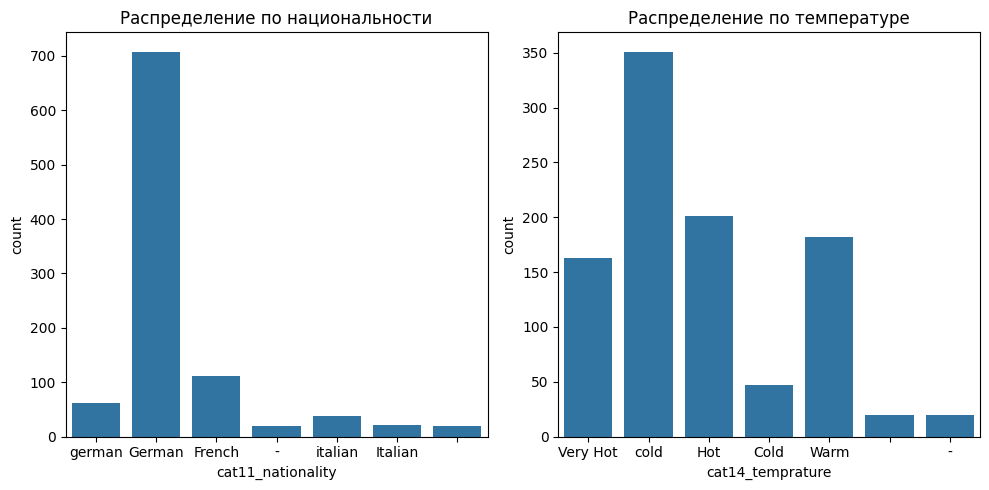

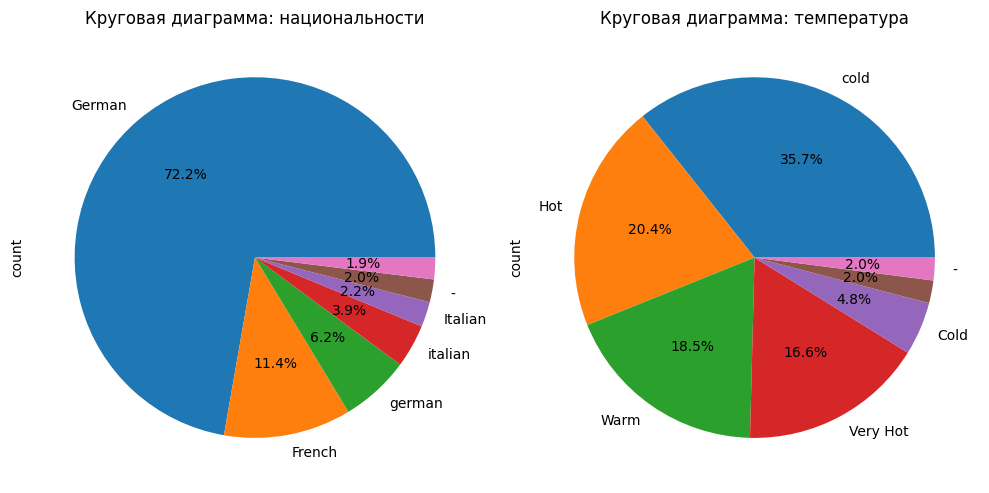

In [3]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='cat11_nationality', data=data)
plt.title('Распределение по национальности')
plt.subplot(1, 2, 2)
sns.countplot(x='cat14_temprature', data=data)
plt.title('Распределение по температуре')
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
data['cat11_nationality'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Круговая диаграмма: национальности')
plt.subplot(1, 2, 2)
data['cat14_temprature'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Круговая диаграмма: температура')
plt.tight_layout()
plt.show()

### Гистограмма, оценка плотности распределения и диаграмма «ящик с усами» для количественных переменных

/tmp/ipykernel_46358/1191811256.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_copy[column] = data_copy[column].replace([r'^\s+$', r'-'], np.nan, regex=True)


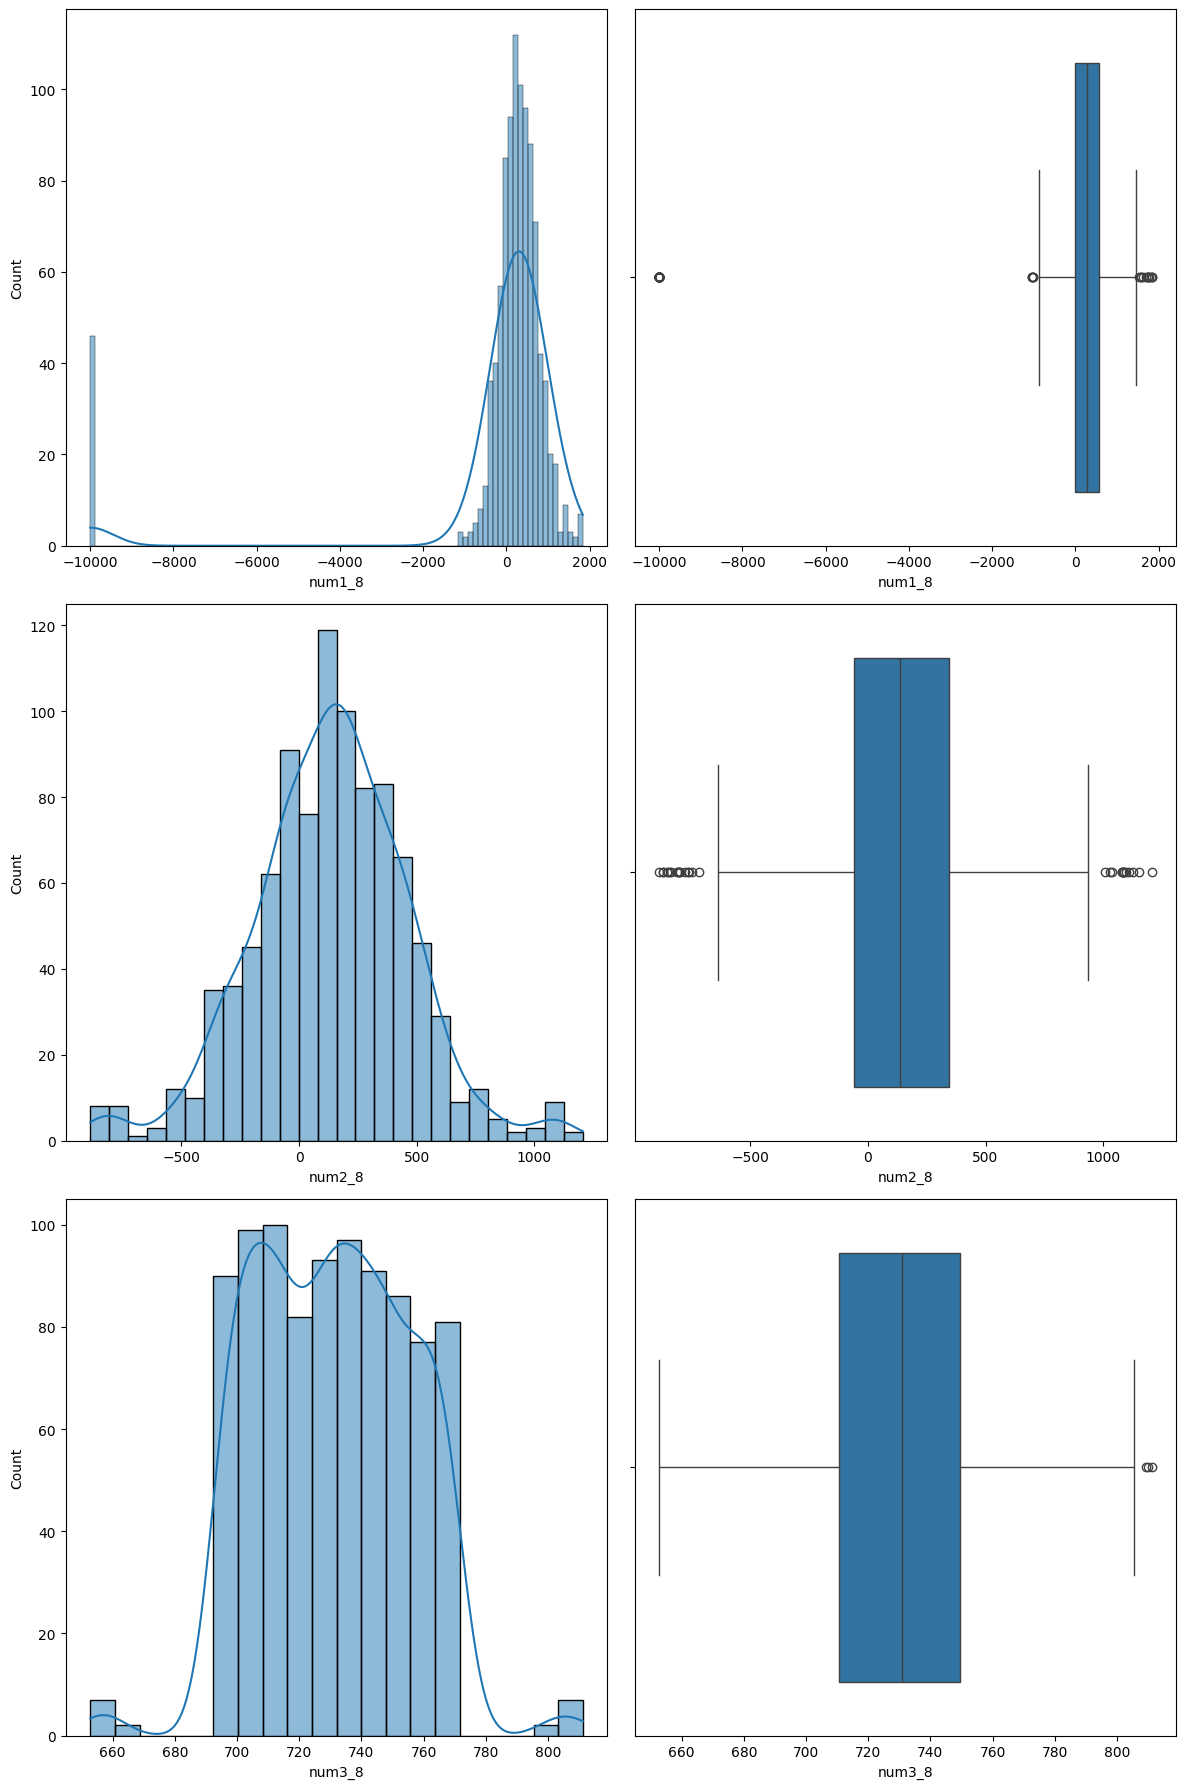

In [4]:
data_copy = data.copy(deep=True)

columns = ['num1_8', 'num2_8', 'num3_8']
for column in columns:
    # Замена пустых строк и символов '-' на NaN
   data_copy[column] = data_copy[column].replace([r'^\s+$', r'-'], np.nan, regex=True)



fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 18))

axes_iterator = iter(axes.flatten())
 
for column in columns:
    sns.histplot(data=data_copy, x=column, kde=True, ax=next(axes_iterator))
    sns.boxplot(x=data_copy[column], ax=next(axes_iterator))

plt.tight_layout()
plt.show()

## 2. Проверка правдоподобности данных

In [5]:
data = data.copy(deep=True)
data['cat11_nationality'] = data['cat11_nationality'].str.upper()
data['cat14_temprature'] = data['cat14_temprature'].str.upper()
# Замена некорректных значений в столбцах 'cat11_nationality' и 'cat14_temprature' на NaN

for col in ['cat11_nationality', 'cat14_temprature']:
    # Замена пустых строк и символов '-' на NaN в столбцах 'cat11_nationality', 'cat14_temprature'
    data[col] = data[col].replace([r'^\s+$', r'-'], np.nan, regex=True)
    data_filter = ~data[col].astype(str).str.isalpha() # 1 если есть буквенные символы, 0 если хотя бы 1 не буквенный
    data.loc[data_filter, col] = np.nan

# Замена значений -9999 на NaN в столбцах 'num1_8', 'num2_8', 'num3_8'
data[['num1_8', 'num2_8', 'num3_8']] = data[['num1_8', 'num2_8', 'num3_8']].replace(-9999, np.nan)

# Замена пустых строк и символов '-' на NaN в столбцах 'num1_8', 'num2_8', 'num3_8'
for col in ['num1_8', 'num2_8', 'num3_8']:
    data[col] = data[col].replace([r'^\s+$', r'-'], np.nan, regex=True)

data

/tmp/ipykernel_46358/748221793.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[col] = data[col].replace([r'^\s+$', r'-'], np.nan, regex=True)


,cat11_nationality,cat14_temprature,num1_8,num2_8,num3_8
0,GERMAN,NaN,247.159357,233.346229,731.516449
1,GERMAN,COLD,668.812973,96.173995,726.139127
2,GERMAN,NaN,236.218871,1.799639,742.322785
3,GERMAN,NaN,989.929212,526.862875,767.297661
4,GERMAN,COLD,88.636793,64.834346,767.944298
...,...,...,...,...,...
995,FRENCH,NaN,693.456750,62.973627,756.731417
996,GERMAN,COLD,172.961735,64.458428,713.537068
997,GERMAN,NaN,196.283378,33.545698,750.001161
998,GERMAN,NaN,-133.377671,426.799833,729.385345


## 3. Поиск аномальных значений

In [6]:
# Определяем порог для сигм
threshold = 3

# Применяем метод сигм и удаляем из data аномальные значения
c, low, upp = sc.stats.sigmaclip(data['num1_8'].dropna(), threshold, threshold)

data_cleaned_sigma = data[(data['num1_8'] >= low) & (data['num1_8'] <= upp)]
data_bad_values = data[(data['num1_8'] <= low) | (data['num1_8'] >= upp)]

# Метод квартилей
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - IQR
    upper_bound = Q3 + IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

data_cleaned_iqr = remove_outliers_iqr(data, 'num1_8')


print('🗿 sigma moment 🗿\n', data_cleaned_sigma)
print('IQR\n', data_cleaned_iqr)

🗿 sigma moment 🗿
     cat11_nationality cat14_temprature      num1_8      num2_8      num3_8
0              GERMAN              NaN  247.159357  233.346229  731.516449
1              GERMAN             COLD  668.812973   96.173995  726.139127
2              GERMAN              NaN  236.218871    1.799639  742.322785
3              GERMAN              NaN  989.929212  526.862875  767.297661
4              GERMAN             COLD   88.636793   64.834346  767.944298
..                ...              ...         ...         ...         ...
995            FRENCH              NaN  693.456750   62.973627  756.731417
996            GERMAN             COLD  172.961735   64.458428  713.537068
997            GERMAN              NaN  196.283378   33.545698  750.001161
998            GERMAN              NaN -133.377671  426.799833  729.385345
999            GERMAN             COLD  -72.979302  464.629839  732.606965

[938 rows x 5 columns]
IQR
     cat11_nationality cat14_temprature      num1_8   

## 4. Поиск и восстановление пропущенных значений

In [7]:
data_cleaned_sigma.reset_index(drop=True, inplace=True)

data = data_cleaned_sigma

# Поиск пропущенных значений
missing_data = data.isnull().sum()
print("Статистика по пропущенным значениям\n", missing_data)
ohe = OneHotEncoder(drop='first', sparse_output=False)
 
encoded_data = pd.DataFrame(ohe.fit_transform(data[['cat11_nationality']]))
encoded_data.columns = ohe.get_feature_names_out()
 
data_onehot = data.join(encoded_data)
data_onehot.drop('cat11_nationality', axis = 1, inplace = True)
encoded_values = encoded_data.to_numpy()
data_onehot['cat11_nationality'] = list(map(lambda x: np.argmax(x), encoded_values))
data_onehot.drop(encoded_data.columns, axis=1, inplace=True)

print(data_onehot)
data = data_onehot

# Восстановление пропущенных значений
# K ближайших соседей для первого признака
imputer = KNNImputer(n_neighbors=5)
features = ['cat11_nationality', 'num1_8']
data['cat11_nationality'] = imputer.fit_transform(data[features])


# Замена пропущенных значений самым популярным значением для второго признака
data['cat14_temprature'] = data['cat14_temprature'].fillna(data['cat14_temprature'].mode()[0])

# Замена пропущенных значений средним значением для третьего признака
data['num1_8'] = data['num1_8'].fillna(data['num1_8'].mean())

# Замена пропущенных значений медианой для четвертого признака
data['num2_8'] = data['num2_8'].fillna(data['num2_8'].median())

# K ближайших соседей для пятого признака
data['num3_8'] = imputer.fit_transform(data[['num3_8']])

data


Статистика по пропущенным значениям
 cat11_nationality     54
cat14_temprature     206
num1_8                 0
num2_8                45
num3_8                79
dtype: int64
    cat14_temprature      num1_8      num2_8      num3_8  cat11_nationality
0                NaN  247.159357  233.346229  731.516449                  0
1               COLD  668.812973   96.173995  726.139127                  0
2                NaN  236.218871    1.799639  742.322785                  0
3                NaN  989.929212  526.862875  767.297661                  0
4               COLD   88.636793   64.834346  767.944298                  0
..               ...         ...         ...         ...                ...
933              NaN  693.456750   62.973627  756.731417                  0
934             COLD  172.961735   64.458428  713.537068                  0
935              NaN  196.283378   33.545698  750.001161                  0
936              NaN -133.377671  426.799833  729.385345         

,cat14_temprature,num1_8,num2_8,num3_8,cat11_nationality
0,COLD,247.159357,233.346229,731.516449,0.0
1,COLD,668.812973,96.173995,726.139127,0.0
2,COLD,236.218871,1.799639,742.322785,0.0
3,COLD,989.929212,526.862875,767.297661,0.0
4,COLD,88.636793,64.834346,767.944298,0.0
...,...,...,...,...,...
933,COLD,693.456750,62.973627,756.731417,0.0
934,COLD,172.961735,64.458428,713.537068,0.0
935,COLD,196.283378,33.545698,750.001161,0.0
936,COLD,-133.377671,426.799833,729.385345,0.0


## 5. Преобразование данных

In [8]:

# Стандартизация и нормализация числовых признаков
scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
label_encoder = LabelEncoder()
data[['num1_8', 'num2_8', 'num3_8']] = scaler.fit_transform(data[['num1_8', 'num2_8', 'num3_8']])
data[['num1_8', 'num2_8', 'num3_8']] = minmax_scaler.fit_transform(data[['num1_8', 'num2_8', 'num3_8']])

# One-hot encoding для категориального признака cat16_city
#cat16_encoded = one_hot_encoder.fit_transform(data[['cat16_city']]).toarray()

# Label encoding для категориального признака cat11_nationality
data['cat14_temprature'] = label_encoder.fit_transform(data['cat14_temprature'])

data

,cat14_temprature,num1_8,num2_8,num3_8,cat11_nationality
0,0,0.466800,0.535214,0.497087,0.0
1,0,0.641417,0.469732,0.463114,0.0
2,0,0.462269,0.424680,0.565360,0.0
3,0,0.774400,0.675331,0.723148,0.0
4,0,0.401152,0.454771,0.727233,0.0
...,...,...,...,...,...
933,0,0.651623,0.453883,0.656392,0.0
934,0,0.436073,0.454592,0.383496,0.0
935,0,0.445731,0.439835,0.613871,0.0
936,0,0.309210,0.627563,0.483623,0.0


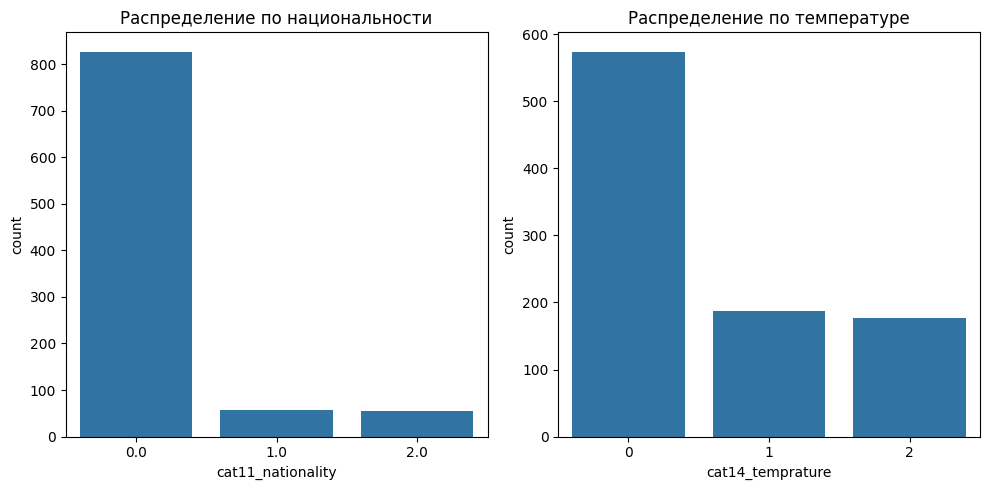

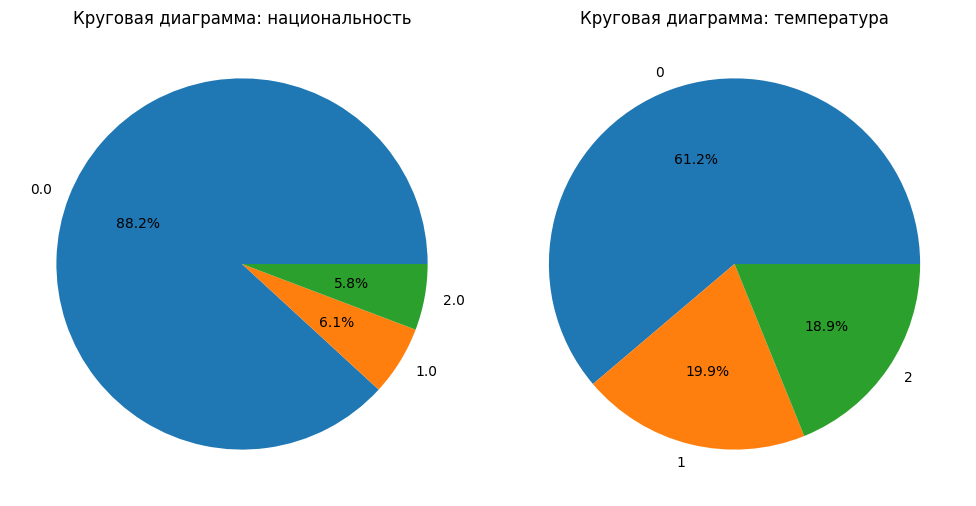

In [9]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='cat11_nationality', data=data)
plt.title('Распределение по национальности')
plt.subplot(1, 2, 2)
sns.countplot(x='cat14_temprature', data=data)
plt.title('Распределение по температуре')
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
data['cat11_nationality'].value_counts().plot(kind='pie', autopct='%1.1f%%', ylabel='')
plt.title('Круговая диаграмма: национальность')
plt.subplot(1, 2, 2)
data['cat14_temprature'].value_counts().plot(kind='pie', autopct='%1.1f%%', ylabel='')
plt.title('Круговая диаграмма: температура')
plt.tight_layout()
plt.show()